<a href="https://colab.research.google.com/github/AshrithSagar/MBM-HS-1/blob/main/Project_Aqua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

Enter peptide sequence, protein file, ...

In [ ]:
#@title Inputs for the Modification cycle

from google.colab import files
import os.path
import re
import hashlib
import random

main_jobname = '' #@param {type:"string"}

# Peptide
main_peptide_sequence = "" #@param {type:"string"}

# Protein
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  os.rename(fn, "main_protein.pdb")


# Structure prediction


> Predict the structure of the peptide ...

In [ ]:
query_sequence = $peptide_sequence

In [ ]:
#@title Inputs for structure prediction

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

# query_sequence = 'ABCDE' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer

# remove whitespaces
query_sequence = "".join(query_sequence.split())

jobname = 'test' #@param {type:"string"}
# remove whitespaces
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)
while os.path.isfile(f"{jobname}.csv"):
  jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))

with open(f"{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path=f"{jobname}.csv"

# number of models to use
use_amber = True #@param {type:"boolean"}
template_mode = "none" #@param ["none", "pdb70","custom"]
#@markdown - "none" = no template information is used, "pdb70" = detect templates in pdb70, "custom" - upload and search own templates (PDB or mmCIF format, see [notes below](#custom_templates))

if template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = f"{jobname}_template"
  os.mkdir(custom_template_path)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn, f"{jobname}_template/{fn}")
else:
  custom_template_path = None
  use_templates = False


In [ ]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "MMseqs2 (UniRef+Environmental)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
pair_mode = "unpaired+paired" #@param ["unpaired+paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired+paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if msa_mode.startswith("MMseqs2"):
  a3m_file = f"{jobname}.a3m"
elif msa_mode == "custom":
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [ ]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "AlphaFold2-ptm", "AlphaFold2-multimer-v1", "AlphaFold2-multimer-v2"]
#@markdown - "auto" = protein structure prediction using "AlphaFold2-ptm" and complex prediction "AlphaFold-multimer-v2". For complexes "AlphaFold-multimer-v[1,2]" and "AlphaFold-ptm" can be used.
num_recycles = 3 #@param [1,3,6,12,24,48] {type:"raw"}
save_to_google_drive = False #@param {type:"boolean"}

#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.


if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

In [ ]:
#@title Install dependencies
%%bash -s $use_amber $use_templates

set -e

USE_AMBER=$1
USE_TEMPLATES=$2

if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
  # high risk high gain
  pip install -q "jax[cuda11_cudnn805]>=0.3.8,<0.4" -f https://storage.googleapis.com/jax-releases/jax_releases.html
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  touch AMBER_READY
fi

In [ ]:
#@title Run Prediction

import sys

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
K80_chk = !nvidia-smi | grep "Tesla K80" | wc -l
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt


# For some reason we need that to get pdbfixer to import
if use_amber and '/usr/local/lib/python3.7/site-packages/' not in sys.path:
    sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')

def prediction_callback(unrelaxed_protein, length, prediction_result, input_features, type):
  fig = plot_protein(unrelaxed_protein, Ls=length, dpi=150)
  plt.show()
  plt.close()

result_dir="."
setup_logging(Path(".").joinpath("log.txt"))
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)
download_alphafold_params(model_type, Path("."))
run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    use_amber=use_amber,
    msa_mode=msa_mode,    
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    recompile_padding=1.0,
    rank_by="auto",
    pair_mode=pair_mode,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi
)

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(f"{jobname}{jobname_prefix}_PAE.png")
cov = image_to_data_url(f"{jobname}{jobname_prefix}_coverage.png")
plddt = image_to_data_url(f"{jobname}{jobname_prefix}_plddt.png")
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

!zip -FSr $jobname".result.zip" config.json $jobname*".json" $jobname*".a3m" $jobname*"relaxed_rank_"*".pdb" "cite.bibtex" $jobname*".png"
files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

# Docking

> Docking the ...

# Molecular dynamics

| MDS

#Lab.07 / IBM3202 – Molecular Dynamics on GROMACS

###Theoretical aspects

As we discussed in class, the core mechanism of **molecular dynamics (MD)** is **numerically solving Newton’s equation of motion** by deriving the **potential energy** (i.e. the energy of bonded and non-bonded interactions) for each atom during propagation of their changes in position upon time. These changes in position are the consequence of both **atom-atom interactions** and **thermal motions** (kinetic energy).

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/MD_01.png'/>
<figcaption>FIGURE 1. The performance (ns/day) of molecular dynamics simulations depend on (A) the number of atoms of the simulated system and (B) the use of CPU alone or combined with GPU nodes for performing the simulations. <br> Kutzner C et al (2014) <i> IOS Press, 722-730</i>; Kutzner C et al (2019) <i> J Comput Chem 40(27), 2418-2431</i></figcaption></center>
</figure>

As most of the potential energy is a pairwise calculation, with **most of these calculations corresponding to non-bonded interactions** (and requiring switching functions and distance cut-off strategies to reduce their computational costs), the **time required for solving these equations exponentially increases with the number of particles in the system**. In previous years, these computational needs were typically alleviated with costly hardware investments in CPU computing power. But during the last years, several MD simulation packages have been developed to compute most (if not all of) **non-bonded interactions** on consumer-grade GPUs, off-loading the CPU and generating significant speedups in affordable computers.

Luckily for us, the advent of **cloud computing** and the emergence of **Google Colab** heavily relies on the use of GPUs. Thus, these cloud services can be efficiently use to perform **10 to 100 ns-long MD simulations**.



##Experimental Overview

Inspired by the COVID-19 pandemic, in this laboratory session we will perfom an MD simulation of the **papain-like protease of SARS-CoV-2**, a current drug-design target to combat this virus.

For our laboratory session, we will compile and install **GROMACS**, an MD simulation package that we will use to set-up and perform our simulations. We will visualize our protein structure using **py3Dmol**, while the simulation trajectories from our MD production runs will be visualized in a web version of **NGLview**. We will also analyze some parameters regarding the proper equilibration of our simulation system, but a deeper analysis of protein motions will take case in the next tutorial.

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/MD_02.jpg' />
<figcaption>FIGURE 2. General steps for performing MD simulations. Starting from a experimental or modelled protein structure, a simulation system is prepared by setting up a simulation box, solvating the protein with water and neutralizing the total charge of the system with counterions. Then, the simulations are performed, visualized and analyzed in terms of their protein motions and energetic features<br>Morgnanesi D et al (2015) <i>Antiviral Res 123, 204-215</i></figcaption></center>
</figure>

#Part 0. Downloading and Installing the required software

Before we start, you must:
1. Remember to **start the hosted runtime** in Google Colab.
2. **VERY IMPORTANT‼️** Go to *Runtime* -> *Change Runtime Type* and select GPU.

Then, we must install three pieces of software to perform this tutorial. Namely:
- **biopython** for manipulation of the PDB files
- **py3Dmol** for visualization of the protein structure.
- **GROMACS** for preparing our MD system and performing our MD simulations.


For visualizing our MD trajectories, we will employ a web version of **NGLview**. This is due to the inability of Google Colab to handle a required python package for loading NGLview directly onto Google Colab. Hopefully this will change in the near future.
The analysis of our trajectories will be mostly performed on the next laboratory session!

1. We will first start by setting up **GROMACS** on Google Colab, based on a  previously compiled and installed GROMACS.

In [ ]:
# Download and unzip the compressed folder of GROMACS 2020.6 version
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs.tar.gz
!tar xzf gromacs.tar.gz

--2022-06-28 16:48:55--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35608971 (34M) [application/octet-stream]
Saving to: ‘gromacs.tar.gz’

gromacs.tar.gz      100%[===================>]  33.96M   174MB/s    in 0.2s    

2022-06-28 16:48:56 (174 MB/s) - ‘gromacs.tar.gz’ saved [35608971/35608971]



In [ ]:
# It is recommended (and required for GROMACS 2021) to upgrade cmake
!pip install cmake --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Checking that our GROMACS works
%%bash
source /content/gromacs/bin/GMXRC
gmx -h

SYNOPSIS

gmx [-[no]h] [-[no]quiet] [-[no]version] [-[no]copyright] [-nice <int>]
    [-[no]backup]

OPTIONS

Other options:

 -[no]h                     (no)
           Print help and quit
 -[no]quiet                 (no)
           Do not print common startup info or quotes
 -[no]version               (no)
           Print extended version information and quit
 -[no]copyright             (yes)
           Print copyright information on startup
 -nice   <int>              (19)
           Set the nicelevel (default depends on command)
 -[no]backup                (yes)
           Write backups if output files exist

Additional help is available on the following topics:
    commands    List of available commands
    selections  Selection syntax and usage
To access the help, use 'gmx help <topic>'.
For help on a command, use 'gmx help <command>'.


                         :-) GROMACS - gmx, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
        M

2. Now, we will install **py3Dmol** as follows:

In [ ]:
#Installing py3Dmol using pip
!pip install py3Dmol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importing py3Dmol for safety
import py3Dmol

3. Finally, we will install **biopython**

In [ ]:
#Installing biopython using pip
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.8 MB/s 


Once these software installation processes are completed, we are ready to perform our experiments

# Part I – Setting up the MD simulation system

GROningen Machine for Chemical Simulations (**GROMACS**) is an open-source, free software developed by the University of Groningen with consistent and continuous support. It also has been optimized for calculations by maximizing the usage of all available computational resources (GPU and CPU). Once installed, you can access all the modules it has for setting up, running and analyzing MD simulations by just inputting:

**`gmx [module]`**

The list of modules can be displayed when **`[module]=help`**. Try it out here!

In [ ]:
#We will constantly need to source GMXRC for GROMACS to work
%%bash
source /content/gromacs/bin/GMXRC

#Try gmx here!


The initial steps of setting up a system for MD simulations are:

1. **Cleaning up** the input atomic coordinates
2. **Parameterizing** the atoms building up our system
3. **Solvating** our protein (and adding a lipid membrane in the case of membrane proteins)
4. **Adding** counterions to neutralize the global charge of the system

### Part I.1 – Cleaning up the input atomic coordinates

For this step, we first need an initial set of atomic coordinates, usually coming from a protein structure downloaded from the Protein Data Bank. Once download, these PDB files must be cleaned from water molecules (in the case of crystal structures) or a single model must be selected from the many solutions for a single set of chemical shifts (in the case of NMR structures).

1. We will first start by making a folder for preparing our system and running our simulations, as we have done in the past (remember our Molecular Docking tutorial?)

In [ ]:
#Let's make a folder first. We need to import the os and path library
import os
from pathlib import Path 

#Then, we define the path of the folder we want to create.
#Notice that the HOME folder for a hosted runtime in colab is /content/
mdpath = Path("/content/md01/")

#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(mdpath):
  print("path already exists")
if not os.path.exists(mdpath):
  os.mkdir(mdpath)
  print("path was succesfully created")

path was succesfully created


2. Then, we will change directory to this newly created folder and download the recently X-ray solved structure of the papain-like protease (PLpro) of SARS-CoV-2 (PDB 6WZU).

In [ ]:
#First, we will change to the new folder. We will use python now :)
os.chdir(mdpath)

In [ ]:
#[Modified] Upload your PDB file here.
import os
from google.colab import files
from Bio.PDB import *

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  os.rename(fn, "main_file.pdb")

Saving trial on model0.pdb to trial on model0.pdb
User uploaded file "trial on model0.pdb" with length 1270179 bytes


3. This structure has a few residues in two different conformations (remember when we discussed **occupancy** in classes and during our second tutorial?). We can filter out one of them,  

In [ ]:
#Here we set up a parser for our PDB
parser = PDBParser()
io=PDBIO()
structure = parser.get_structure('X', 'main_file.pdb')
#[MODIFY HERE] And here we set the residue conformation we want to keep
keepAltID = "A"

class KeepOneConfOnly(Select):  # Inherit methods from Select class
    def accept_atom(self, atom):
        if (not atom.is_disordered()) or atom.get_altloc() == keepAltID:
            atom.set_altloc(" ")  # Eliminate alt location ID before output.
            return True
        else:  # Alt location was not one to be output.
            return False
        # end of accept_atom()

#This will keep only conformation for each residue
io.set_structure(structure)
io.save("main_file_ready.pdb", select=KeepOneConfOnly())
print("Your pdb was processed. Alternative side chain conformations removed!")

/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 38, ' ') redefined at line 13449.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/PDBParser.py:421: PDBConstructionWarning: PDBConstructionException: Blank altlocs in duplicate residue ILE (' ', 38, ' ') at line 13449.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 39, ' ') redefined at line 13458.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/PDBParser.py:421: PDBConstructionWarning: PDBConstructionException: Blank altlocs in duplicate residue PRO (' ', 39, ' ') at line 13458.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilde

Your pdb was processed. Alternative side chain conformations removed!


4. Commonly, crystallographic waters and other solvent molecules are stripped from the experimentally solved structure before preparing the MD system. This is also useful for removing hydrogens, which are often found in NMR structures, as they are a nightmare to pass through the atomic conventions of a given force field. We can do this using `Dice` from **biopython** as show in the code cell bellow.

❗️**NOTE:** This procedure is not universally appropriate. Some water molecules could be essential for the function of a protein and thus maintained in the simulation. Also, `Dice` removes ligands, which in some cases need to be maintained depending on the goal of your simulations and the ability to parameterize your ligands. Sometimes, it will be more useful to use `grep`. For example:

  `!grep -v "HOH" 6WZU_ready.pdb > 6WZU_clean.pdb`
  
  This grep command would remove only water molecules from the PDB file.

In [ ]:
#Here we set up a parser for our PDB
parser = PDBParser()
io=PDBIO()
structure = parser.get_structure('X', 'main_file_ready.pdb')
#And here we remove hydrogens, waters and ligands using Dice
io.set_structure(structure)
sel = Dice.ChainSelector('A', 1, 5000)
io.save("main_file_clean.pdb", sel)
print("Your pdb was processed. Only the protein heavy atoms have been kept!")

Your pdb was processed. Only the protein heavy atoms have been kept!


5. Let's load the protein that we are working with using py3dmol

In [ ]:
#First we assign the py3Dmol.view as view
view=py3Dmol.view()
#The following lines are used to add the addModel class
#to read the PDB files
view.addModel(open('main_file_clean.pdb', 'r').read(),'pdb')
#Here we set the background color as white
view.setBackgroundColor('white')
#Here we set the visualization style and color
view.setStyle({'chain':'A'},{'cartoon': {'color':'spectrum'}})
#Centering view on all visible atoms
view.zoomTo()
#And we finally visualize the structures using the command below
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Part I.2 – Parameterizing the atoms building up our system

Now, we will work with GROMACS to parameterize our protein, generating:

*   A **.gro** or **.pdb** coordinate file that contains all the atom types as defined by a given force field (including hydrogens).
*   A **.top** topology file containing the parameters for bonds, angles, dihedrals and non-bonded interactions defined by a given force field (potential energy function) to employ in our simulations.

1. We will parameterize our protein using the **AMBER99SB-ILDN force field** on GROMACS and obtain these files using `gmx` as shown in the code cell below. This force field is extensively used in MD simulations and has parameters that well-represent the dynamics and flexibility of folded proteins. Notice that the dynamics of highly motile proteins or intrinsically disordered regions is not the main dataset for which this force field was parameterized, and other options may better suit such goals.

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#Using pdb2gmx to parameterize our PDB with the AMBER forcefield and SPC/E water
gmx pdb2gmx -f main_file_clean.pdb -o main_file_processed.pdb -water spce -ignh -ff amber99sb-ildn


Using the Amber99sb-ildn force field in directory amber99sb-ildn.ff

going to rename amber99sb-ildn.ff/aminoacids.r2b
going to rename amber99sb-ildn.ff/dna.r2b
going to rename amber99sb-ildn.ff/rna.r2b
Reading main_file_clean.pdb...
Read '', 6797 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 882 residues with 6797 atoms

  chain  #res #atoms
  1 'A'   882   6797  

Reading residue database... (Amber99sb-ildn)
Processing chain 1 'A' (6797 atoms, 882 residues)
Identified residue LEU38 as a starting terminus.
Identified residue ARG37 as a ending terminus.
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 882 residues with 13660 atoms
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: main_file_clean.pdb.
The Amber99sb-ildn force field and the spce water model are used.
		--------- ETON ESAELP ------------

                     :-) GROMACS - gmx pdb2gmx, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

When using this command, the `-f` option corresponds to the input file, the `-ff` option allows to define the force field to be used and the `-o` option provides the output name for the .coordinate file. The topology file receives a default `topol.top` name, although this can be altered with the `-p` option. 

We are also indicating the type of water molecule that we will be using in our simulations through the `-water` option. Yes, there are many water models, but their features are outside the scope of our tutorial. Our selected water model is SPC/E (simple point charge - extended), which models water molecules as a 3-point molecule, each with its own charge. TIP3P is a more common water model, similar to SPC/E but with slightly different parameters. The accuracy of the model used changes depending on the calculations that you will perform, as their dynamic and energetics will differ.

❗️**NOTE:** When working with NMR files, it is useful to incorporate the `-ignh` option, that allows to ignore hydrogens contained in the PDB file. During parameterization, hydrogens are always added back by the force field, as it contains the typical distance parameters for all atoms based on experimental/quantum mechanics analysis.

### Part I.3 – Solvating our protein

We will now define a periodic box for our simulation system, in which our protein will be centered ,and then fill this box with water molecules, thus solvating our protein.

Given the use of **periodic boundary conditions** and the computational costs of the evaluation of non-bonded interactions, it is imperative to properly define the distance of the periodic box such that it is large enough to avoid interactions between our molecule and its periodic images, while at the same time minimizing the number of water molecules (in essence, the number of non-bonded interactions to evaluate during the simulation).

It is often recommended for globular proteins to have a **padding distance** between the furthest protein atom from the center of the periodic box and its edges of 1.0-1.5 nm. If your system has one dimension much larger than the others (i.e. fibrillar proteins) you may wish to draw this periodic box more carefully. 

1. First, we will generate a periodic box using `editconf` as follows:

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#Using editconf to create a cubic box with 1.0 nm padding for our solvated system
gmx editconf -f main_file_processed.pdb -o main_file_newbox.pdb -c -d 1.0 -bt cubic

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 13660 atoms
No velocities found
    system size : 16.184 11.268 16.087 (nm)
    diameter    : 22.772               (nm)
    center      :  1.298 -0.264 -0.320 (nm)
    box vectors :  0.000  0.000  0.000 (nm)
    box angles  :   0.00   0.00   0.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       : 11.088 12.650 12.706 (nm)
new center      : 12.386 12.386 12.386 (nm)
new box vectors : 24.772 24.772 24.772 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :15201.32               (nm^3)


                     :-) GROMACS - gmx editconf, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
    

The options provided to `editconf` enable to center (`-c`) the atom coordinates of our protein (`-f`) in a cubic box (`-bt cubic`) with a padding distance of 1.0 nm from the box edge (`-d 1.0`).

Given periodic boundary conditions, this means that the system will be at the closest 2.0 nm from itself, in which most of the non-bonded terms are out of range between periodic images due to the use of distance cut-offs. Thus, the only molecules that will be interacting between the edges of the periodic box are water molecules and ions. These new coordinates and simulation box are saved in a new coordinate file (`-o`).

2. Once the periodic box is defined, we proceed to fill this box with water molecules using `solvate`. To do this, we execute:

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#Using solvate to fill up our box with water molecules
gmx solvate -cp main_file_newbox.pdb -o main_file_solv.pdb -p topol.top


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------

Adding line for 495644 solvent molecules with resname (SOL) to topology file (topol.top)


                     :-) GROMACS - gmx solvate, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Please note that, given the addition of water molecules to our simulation system, we are generating **a new topology file** (`-p` option) and **a new coordinate file with added water molecules** (`-o` option).

Whenever we write a new topology file (or any file with the same name), GROMACS backups the previous file by adding a `#` symbol (i.e. `#topol.top.1`) and then generates the new .top file. This way you do not have to worry about backing up the files.

**QUESTION❓:** From reading the output of the previous command, how many water molecules were added? 

3. Let's look at the solvated system using py3Dmol! How are the water molecules solvating the protein? Are the molecules homogeneously distributed?

In [ ]:
#First we assign the py3Dmol.view as view
view=py3Dmol.view()
#The following lines are used to add the addModel class
#to read the PDB files
view.addModel(open('main_file_solv.pdb', 'r').read(),'pdb')
#Here we set the background color as white
view.setBackgroundColor('white')
#Here we set the visualization style and color
view.setStyle({'cartoon': {'color':'green'}})
#Here we add a style for showing the oxygen from water molecules
view.addStyle({'atom':'OW'},{'sphere':{'radius':'0.2'}})
#Centering the view on all visible atoms
view.zoomTo()
#And we finally visualize the structures using the command below
view.show()

## Part I.4 – Adding counterions to neutralize the global charge of the system

Now we have a solvated box, but our system has a **non-zero charge**. This is an issue, as each periodic box will have a formal charge, which would cause electrostatic potentials to become unrealistically high among periodic images. Thus, we need to neutralize the charges of our simulation system.

1. Let's easily determine the absolute charge in our system by using `grep`

In [ ]:
!grep "qtot" topol.top

    21          O     38    LEU      O     21    -0.5713         16   ; qtot 1
    37          O     39    VAL      O     37    -0.5679         16   ; qtot 1
    53          O     40    VAL      O     53    -0.5679         16   ; qtot 1
    75          O     41    LYS      O     75    -0.5894         16   ; qtot 2
    86          O     42    SER      O     86    -0.5679         16   ; qtot 2
   105          O     43    ILE      O    105    -0.5679         16   ; qtot 2
   122          O     44    HIS      O    122    -0.5679         16   ; qtot 2
   134          O     45    ASP      O    134    -0.5819         16   ; qtot 1
   144          O     46    ALA      O    144    -0.5679         16   ; qtot 1
   151          O     47    GLY      O    151    -0.5679         16   ; qtot 1
   168          O     48    GLN      O    168    -0.5679         16   ; qtot 1
   192          O     49    ARG      O    192    -0.5894         16   ; qtot 2
   208          O     50    VAL      O    208    -0.

**QUESTION❓:** What is the total charge of our system?

To neutralize the simulation system, we will replace water molecules with the counterions required to get the absolute charge of the system to **zero**. While this might be sufficient for globular proteins in water, in some cases you might find more useful to reach a particular salt concentration or generate charge differences, for example in the case of simulations of ion channels in a lipid bilayer.

2. The addition of counterions is achieved by building a **portable binary run input file for GROMACS**, or **.tpr file**. This file contains the information from the coordinates, topology/parameters and an **MD instruction file** (**.mdp**). This instruction file contains all the parameters that will be used for running different calculations, and you can input flags that will be read by those specific programs.

  We will download and use a predefined **ions.mdp** file (**please take a look at it!**) onto our simulation folder and generate the .tpr run input file by executing the following command with the `grompp` module:

In [ ]:
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/ions.mdp
source /content/gromacs/bin/GMXRC

#Using grompp and an MD instruction file to add counterions to our system
gmx grompp -f ions.mdp -c main_file_solv.pdb -p topol.top -o ions.tpr

Analysing residue names:
There are:   882    Protein residues
There are: 495644      Water residues
Analysing Protein...
This run will generate roughly 115 Mb of data


--2022-06-28 16:52:21--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/ions.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 966 [text/plain]
Saving to: ‘ions.mdp’

     0K                                                       100% 65.1M=0s

2022-06-28 16:52:21 (65.1 MB/s) - ‘ions.mdp’ saved [966/966]

                      :-) GROMACS - gmx grompp, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Chr

Please note that, in the case of `grompp`, the `-f` option is now used for the .mdp file, while `-c` is used for the coordinates.

3. Once this is done, run the `genion` module for randomly replacing water molecules in your simulation system with an appropriate number and type of counterions.

❗️**NOTE:** Usually `gmx` would **interactively request us** to choose a group for this replacement (in our case, group 13 "SOL", corresponding to water molecules). Here, we are solving the impediment of doing this on Google Colab by **generating a text file with these options**, which then we pass onto `gmx` to be read

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "SOL" > options
echo " " >> options

#Using genion and the tpr to add counterions to our solvated system
gmx genion -s ions.tpr -o main_file_solv_ions.pdb -p topol.top -pname NA -nname CL -neutral < options

Will try to add 7 NA ions and 0 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 7 solute molecules in topology file (topol.top)  by 7 NA and 0 CL ions.


                      :-) GROMACS - gmx genion, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

**QUESTION❓:** What type of monovalent ion was added? How many ions were added?

We have finalized preparing the simulation system with our protein in the center of a cubic box with 1.0 nm of padding, solvated in water molecules and neutralized with counterions. You can choose to visualize it using py3Dmol if you want!

#Part II – Minimizing and Equilibrating the MD system

Now, we are ready to perform the minimization of our system to eliminate the high energy and forces due to bad initial coordinates, and its equilibration at constant pressure and temperature (NPT ensemble).

1. We will start by downloading an MD instruction file that contains all of the parameters required for the minimization of our system. We will also print its contents for inspection.

In [ ]:
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/em.mdp


--2022-06-28 16:52:30--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/em.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1167 (1.1K) [text/plain]
Saving to: ‘em.mdp’

em.mdp              100%[===================>]   1.14K  --.-KB/s    in 0s      

2022-06-28 16:52:30 (71.3 MB/s) - ‘em.mdp’ saved [1167/1167]



In [ ]:
#Check the content of the MDP file
!paste em.mdp

; em.mdp - used as input into grompp to generate em.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.001         ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet    ; Buffered neighbor searching
rcoulomb        = 1.2       ; Short-range electrostatic cut-off
rvdw            = 1.2       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions

; Electrostatics
coulombtype     = PME       ; Particle Mesh Ewald for long-range electrostatics
pme_order       = 4 

As you can see, the minimization process involves the use of a **steepest descent** (`steep`) integrator. This integrator, alongside conjugate gradient (`cg`) and a quasi-Newtonian method (`l-bfgs`), are **minimization algorithms** that instead of solving the positions for changes in the gradient (Newton’s equation of motion), look for changes in position that would **minimize the potential energy**.

These minimization (sometimes referred to relaxation) protocols make sure that the **starting point from our simulations has a ΔU favorable enough** for Verlet and leapfrog algorithms (which enable the **propagation of changes in atom positions for each time step**) to be numerically integrable.

In simpler words, this step is critical as starting from a high potential energy can generate from highly divergent simulations, in the mildest of cases, to energetic instabilities that would make our system impossible to numerically integrate (typically known as a **“system that explodes”**).


2. We will pre-process our files with `grompp` and then run our MD with `mdrun`. Check the resemblance (and also differences) of the use of `grompp` for adding neutralizing counterions and the system minimization.

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#Using grompp to prepare our minimization MD
gmx grompp -f em.mdp -c main_file_solv_ions.pdb -p topol.top -o em.tpr

#Run our minimization
gmx mdrun -v -deffnm em -nb gpu

Analysing residue names:
There are:   882    Protein residues
There are: 495637      Water residues
There are:     7        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 160x160x160, spacing 0.155 0.155 0.155
This run will generate roughly 115 Mb of data


                      :-) GROMACS - gmx grompp, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

For `mdrun`, we are using the verbose option (`-v`) to output the changes in forces between atoms during the system minimization. As the system is minimized, these forces should be reduced when compared to the initial system.

The `-deffnm` option simply states that all MD-generated files will have the same standard name (in this case, *em*) as the .tpr file generated with `grompp`

**📚HOMEWORK:** Look up which files have been generated after `mdrun`. What is inside each generated file? If you do not know, **Google it!** This step is **obligatory**.

😱 **EMERGENCY BACKUP!** Ran out of time and could not minimize your system? Use the following code cell to download a readily minimized system:

In [ ]:
# #Use only in case of emergency
# !wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/emergency_backup/lab07/6wzu_em.tar.gz
# !tar xzf 6wzu_em.tar.gz

--2022-06-28 17:25:25--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/emergency_backup/lab07/6wzu_em.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4478815 (4.3M) [application/octet-stream]
Saving to: ‘6wzu_em.tar.gz’

6wzu_em.tar.gz      100%[===================>]   4.27M  --.-KB/s    in 0.08s   

2022-06-28 17:25:25 (56.8 MB/s) - ‘6wzu_em.tar.gz’ saved [4478815/4478815]



3. Once our minimization is finished, we can check how the potential energy of the system changes over each minimization step. For this, we will use the `energy` module to extract the potential energy, and then we will plot it using **matplotlib**:

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Potential" > options
echo " " >> options

#Using energy to extract the potential energy of the system
gmx energy -f em.edr -o em_potential.xvg -xvg none < options


Statistics over 1783 steps [ 0.0000 through 1782.0000 ps ], 1 data sets
All statistics are over 1414 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                -2.37062e+06      30000      77735    -199072  (kJ/mol)


                      :-) GROMACS - gmx energy, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

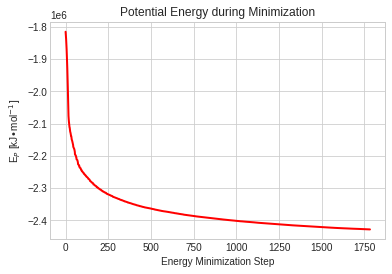

In [ ]:
#Plotting the potential energy of the system
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('em_potential.xvg')

plt.title('Potential Energy during Minimization')
plt.xlabel('Energy Minimization Step')
plt.ylabel(r'E$_P$ [kJ•mol$^{-1}]$')
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red') 
plt.show()

Next, we will start our **equilibration**. This step is required given that we optimized the positions of the atoms according to our force field, but at no point we maximized the interactions between solvent and solute. We also have not established the **kinetic effect of temperature on atom motions** or the **pressure of our system**, thus making it unrelatable to experimental conditions.

Thus, we will **equilibrate the energy and density of our system at constant temperature and pressure** before the MD production runs.

4. The first equilibration step is the **temperature**. Thus, we will start a MD simulation to equilibrate the system at a target temprature (in our case, 300K) using a thermal bath. The initial velocities for the atoms of our system at our target temperatureare obtained through a Maxwell distribution.

  We will first download an appropriate MD instruction file and then run our simulation as we did before for the minimization. Also note that we are now using **GPU resources** for the non-bonded interactions.

In [ ]:
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/nvt.mdp

#Using grompp to prepare our NVT equilibration MD
source /content/gromacs/bin/GMXRC
gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


--2022-06-28 17:25:26--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/nvt.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2464 (2.4K) [text/plain]
Saving to: ‘nvt.mdp’

     0K ..                                                    100% 34.0M=0s

2022-06-28 17:25:26 (34.0 MB/s) - ‘nvt.mdp’ saved [2464/2464]

                      :-) GROMACS - gmx grompp, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupino

In [ ]:
%%time
%%bash
#Run our NVT equilibration MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm nvt -nb gpu

                      :-) GROMACS - gmx mdrun, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
      

CPU times: user 5.18 ms, sys: 8.38 ms, total: 13.6 ms
Wall time: 56.1 ms


😱 **EMERGENCY BACKUP!** Ran out of time and could not perform the NVT equilibration of your system? Use the following code cell to download a temperature-equilibrated system:

In [ ]:
# #Use only in case of emergency
# !wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/emergency_backup/lab07/6wzu_nvt.tar.gz
# !tar xzf 6wzu_nvt.tar.gz

--2022-06-28 17:25:28--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/emergency_backup/lab07/6wzu_nvt.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60787025 (58M) [application/octet-stream]
Saving to: ‘6wzu_nvt.tar.gz’

6wzu_nvt.tar.gz     100%[===================>]  57.97M   209MB/s    in 0.3s    

2022-06-28 17:25:29 (209 MB/s) - ‘6wzu_nvt.tar.gz’ saved [60787025/60787025]



If you take a look at the MD instruction file for this step, you will notice that we are now using a **leapfrog algorithm** (`md`) for propagation of the protein motions upon time.

 Among several parameters, we can read that the **hydrogen atoms are constrained**. This is because those nuclei have little mass and are commonly inside the Lennard-Jones radius of a molecule, lack any type of dihedral motions, and the distance of the bond is highly conserved. This is why constraint algorithms are used to simplify their movement equations, while keeping the effect they have on solvation and interactions. Given that the faster internal motions correspond to the bond vibrations between light atoms (such as hydrogen), their constraining enables the use of **higher timesteps** (in our case, we will use **2 fs**).

Finally, in this equilibration step a **position restraining algorithm** is used to keep the heavy atoms of our protein in place. This is because we know our protein structure is mostly ideal (because it is modeled from experimental data), but our solvent molecules were just drawn around it. So, in this step we will keep our protein mostly in place and let the solvent rearrange around our protein as we would expect it to do at 300 K. This information is in the **posre.itp** (a position restrain file) that was generated at the beginning of the use of GROMACS. This restrain is performed via the `-r em.gro` option.


5. What we just did corresponds to a simulation setup in which the number of atoms, the volume and the temperature are kept constant: **NVT ensemble**. Thus, the temperature of the system should oscillate around the desired temperature (in our case, 300 K). Let's check if this is true!

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Temperature" > options
echo " " >> options

#Using energy to extract the temperature of the system during the NVT equil MD
gmx energy -f nvt.edr -o nvt_temp.xvg -xvg none < options


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 299.795        0.2    3.45564    1.10251  (K)


                      :-) GROMACS - gmx energy, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

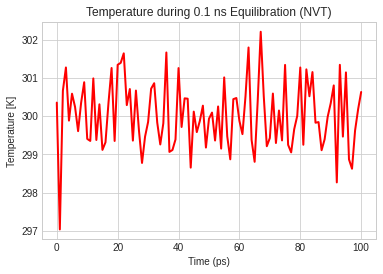

In [ ]:
#Plotting the temperature of the system
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('nvt_temp.xvg')

plt.title('Temperature during 0.1 ns Equilibration (NVT)')
plt.xlabel('Time (ps)')
plt.ylabel('Temperature [K]')
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red') 
plt.show()

6. The final equilibration step will allow us to implement **pressure regulation** to our system, which will maintain the density and pressure of our solvent constant so that it matches what we would expect for the SPC/E water model. Thus, in this case we will be using an ensemble in which the number of atoms, the pressure and the temperature of the system remain constant: **the NPT ensemble**.

  We will perform the same steps we did before: download an MD instruction file, and then use `grompp` and `mdrun` to run the MD simulation. One big difference between this simulation phase and the previous ones is that we will employ a **checkpoint state file** (nvt.cpt), which allows for a numerical continuation of our simulations. This file constitutes a checkpoint of the previous NVT simulation, containing the potential energy of the system and the velocities.

In [ ]:
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/npt.mdp

#Using grompp to prepare our NPT equilibration MD
source /content/gromacs/bin/GMXRC
gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


--2022-06-28 17:25:30--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/npt.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2687 (2.6K) [text/plain]
Saving to: ‘npt.mdp’

     0K ..                                                    100% 42.1M=0s

2022-06-28 17:25:30 (42.1 MB/s) - ‘npt.mdp’ saved [2687/2687]

                      :-) GROMACS - gmx grompp, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupino

In [ ]:
%%time
%%bash
#Run our NPT equilibration MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm npt -nb gpu

                      :-) GROMACS - gmx mdrun, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
      

CPU times: user 3.3 ms, sys: 9.31 ms, total: 12.6 ms
Wall time: 51.1 ms


**⚠️CAUTION:** We used a Parrinello-Rahman barostat instead of Berendsen for the NPT equilibration. This should not be an issue if the system is adequately equilibrated, otherwise the combination of restraints and Parrinello-Rahman would be inappropriate as it could lead to instabilities.

😱 **EMERGENCY BACKUP!** Ran out of time and could not perform the NPT equilibration of your system? Use the following code cell to download a pressure-equilibrated system:

In [ ]:
# #Use only in case of emergency
# !wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/emergency_backup/lab07/6wzu_npt.tar.gz
# !tar xzf 6wzu_npt.tar.gz

--2022-06-28 17:25:32--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/emergency_backup/lab07/6wzu_npt.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61359250 (59M) [application/octet-stream]
Saving to: ‘6wzu_npt.tar.gz’

6wzu_npt.tar.gz     100%[===================>]  58.52M   202MB/s    in 0.3s    

2022-06-28 17:25:33 (202 MB/s) - ‘6wzu_npt.tar.gz’ saved [61359250/61359250]



7. Given that we are using an NPT ensemble to maintain our simulation at constant pressure and density, we should check if this is achieved.

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Pressure" > options
echo "Density" >> options
echo " "

#Using energy to extract the pressure and density of the system during the NPT equil MD
gmx energy -f npt.edr -o npt_press_dens.xvg -xvg none < options

 

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 2 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                  -0.744172        2.4    92.1198    13.5713  (bar)
Density                     1009.57       0.47    3.61762     2.9961  (kg/m^3)


                      :-) GROMACS - gmx energy, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

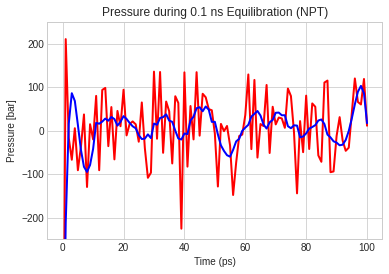

In [ ]:
#Plotting the density of the system
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('npt_press_dens.xvg')

plt.title('Pressure during 0.1 ns Equilibration (NPT)')
plt.xlabel('Time (ps)')
plt.ylabel('Pressure [bar]')
plt.ylim(-250,250)

#Smoothing using Savitzky-Golay
from scipy.signal import savgol_filter
yhat = savgol_filter(data[:,1], 21, 5)

#Plot raw data and spline interpolation
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red')
plt.plot(data[:,0], yhat, linestyle='solid', linewidth='2', color='blue') 
plt.show()

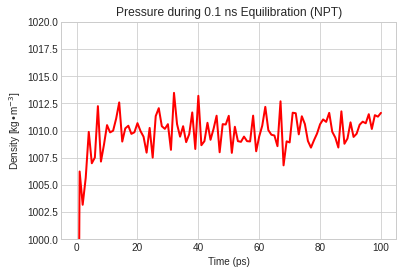

In [ ]:
#Plotting the pressure of the system
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('npt_press_dens.xvg')

plt.title('Pressure during 0.1 ns Equilibration (NPT)')
plt.xlabel('Time (ps)')
plt.ylabel('Density [kg•m$^{-3}$]')
plt.ylim(1000,1020)
plt.plot(data[:,0], data[:,2], linestyle='solid', linewidth='2', color='red') 
plt.show()

**QUESTION❓:** What is the average value of the density along the trajectory? Sounds familiar? 

Once this section is finished, we can move onto production MD simulations.

#Part III – Obtain a production MD run and analyze the results

Now we are ready for running our MD simulations. If we are using a typical NPT ensemble, we can just continue our simulation similar to our second equilibration, but without having any position restraints (without the `-r` option).

1. If you have paid attention to our previous MD runs, you will fully understand what is annotated in the following code cells. Due to time constraints and the size of the system, we are only generating **0.1 ns of production runs**, whilst you will find that simulations in current articles often correspond to hundreds of ns.

In [ ]:
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/md.mdp

#Using grompp to prepare our production MD
source /content/gromacs/bin/GMXRC
gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md_1.tpr

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


--2022-06-28 17:25:34--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/md.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2619 (2.6K) [text/plain]
Saving to: ‘md.mdp’

     0K ..                                                    100% 38.5M=0s

2022-06-28 17:25:34 (38.5 MB/s) - ‘md.mdp’ saved [2619/2619]

                      :-) GROMACS - gmx grompp, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov  

In [ ]:
#Check the content of the production MD file
!paste md.mdp

; Run parameters
integrator              = md        ; leap-frog integrator
nsteps                  = 50000    ; 2 * 50000 = 100 ps (0.1 ns)
dt                      = 0.002     ; 2 fs

; Output control
nstxout                 = 0         ; suppress bulky .trr file by specifying 
nstvout                 = 0         ; 0 for output frequency of nstxout,
nstfout                 = 0         ; nstvout, and nstfout
nstenergy               = 1000      ; save energies every 2.0 ps
nstlog                  = 1000      ; update log file every 2.0 ps
nstxout-compressed      = 1000      ; save compressed coordinates every 2.0 ps
compressed-x-grps       = System    ; save the whole system

; Bond parameters
continuation            = yes       ; Restarting after NPT 
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also relate

In [ ]:
%%time
%%bash
#Run our production MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm md_1 -nb gpu

                      :-) GROMACS - gmx mdrun, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
      

CPU times: user 7.9 ms, sys: 9.07 ms, total: 17 ms
Wall time: 59.7 ms


2. To finalize, we will visualize our simulation. For this, we will use the `trjconv` module to extract only the protein from our system and convert our trajectory into a PDB file.

  Given that our protein may have drifted from the center of the box and reached its edges, we will also take the opportunity to recenter the periodic box on our protein such that its atoms do not stretch through the edges of the periodic boundary conditions using the `-pbc mol` and `-center` options.

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Protein" > options
echo "Protein" >> options
echo " "

#Using trjconv to extract only the protein atoms from the simulation trajectory
#and also recenter the protein if its atoms crossed the periodic boundaries
gmx trjconv -s md_1.tpr -f md_1.xtc -o ff -pbc mol -center < options

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

3. Now, you can download this new PDB file and load it onto [**NGLviewer**](http://nglviewer.org/ngl/) as a **trajectory** PDB file to visualize the protein motions explored within this short simulation time.

😱 **EMERGENCY BACKUP!** If you did not obtain the production MD trajectory on time, you can download <a href="https://github.com/pb3lab/ibm3202/blob/master/files/emergency_backup/lab07/md_1_protPBC.pdb" target="_blank"/>this 0.2 ns trajectory</a> by clicking with the right button on *View Raw* and selecting to download it as a file.

**And this is the end of the seventh tutorial!** On the next tutorial, we will learn how to perform some analysis of our MD production runs. 

If you want to download your results, you can perform the following commands:

In [ ]:
os.chdir("/content/")
!zip -r md.zip $mdpath
from google.colab import files
files.download("/content/md.zip")
os.chdir(mdpath)

  adding: content/md01/ (stored 0%)
  adding: content/md01/step136c.pdb (deflated 80%)
  adding: content/md01/step139c.pdb (deflated 80%)
  adding: content/md01/step87b.pdb (deflated 80%)
  adding: content/md01/#topol.top.2# (deflated 87%)
  adding: content/md01/npt.tpr (deflated 31%)
  adding: content/md01/step72c.pdb (deflated 80%)
  adding: content/md01/main_file.pdb (deflated 79%)
  adding: content/md01/step156b.pdb (deflated 80%)
  adding: content/md01/main_file_processed.pdb (deflated 78%)
  adding: content/md01/em.mdp (deflated 51%)
  adding: content/md01/step70b.pdb (deflated 80%)
  adding: content/md01/em.log (deflated 90%)
  adding: content/md01/step116c.pdb (deflated 80%)
  adding: content/md01/step62c.pdb (deflated 80%)
  adding: content/md01/step71c.pdb (deflated 80%)
  adding: content/md01/.ipynb_checkpoints/ (stored 0%)
  adding: content/md01/main_file_newbox.pdb (deflated 78%)
  adding: content/md01/em.tpr (deflated 76%)
  adding: content/md01/main_file_solv_ions.pdb (d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**📚HOMEWORK:** Once you got here, you can perform several exercises!

1.	Try to perform the equilibration without minimization of the simulation system (i.e. skip the use of em.mdp and go straight onto equilibration).
2.	Change the timestep from 2 fs to 4 fs or 5 fs, and check what happens with the simulation system in terms of stability. If you get some warnings and no .tpr file is compiled, you can add the `-maxwarn X` option, where `X` is the number of warnings from GROMACS that you will ignore.

With these examples, it will be possible to better understand why defining the proper timestep and adequately minimize and equilibrate the system are important steps in all MD simulations.

3. Run your simulation for a longer time (for example, 1 ns; ~ 1 h on Google Colab).